In [1]:
import sys
sys.path.append(".")

import torch
import torch.nn as nn
from matplotlib import pyplot as plt
import copy

In [2]:
from dataset_imae import DataBuilder
from torch.utils.data import DataLoader

In [3]:
class VisionTransformer(nn.Module): 

    def __init__(self, channel_num, patch_len, image_len, device_id):

        super().__init__()
        self.channel_num = channel_num
        self.patch_len = patch_len
        self.image_len = image_len

        self.side_patch_num  = image_len//patch_len
        self.patch_embedding_num = self.side_patch_num**2
        self.patch_embedding_len = channel_num*patch_len*patch_len

        self.start_embedding = nn.Parameter(torch.zeros(1, self.patch_embedding_len))
        self.end_embedding = nn.Parameter(torch.zeros(1, self.patch_embedding_len)) 

        self.pos_embedding = nn.Parameter(torch.randn(self.patch_embedding_num+2, self.patch_embedding_len))*0.02
        self.pos_embedding = self.pos_embedding.to(device_id)

        self.random_tensor = torch.randn(self.channel_num,self.image_len,self.image_len).to(device_id) # for random masking

        
        transform_layer = nn.TransformerEncoderLayer(d_model=self.patch_embedding_len, nhead=6, dropout=0.0, batch_first=True)
        self.transformer = nn.TransformerEncoder(transform_layer, num_layers=6)

        norm_layer=nn.LayerNorm
        self.norm = norm_layer(self.patch_embedding_len)

        self.batch_forward = torch.vmap(self.en_seq_embeddings)
        self.batch_inverse = torch.vmap(self.de_seq_embeddings)

        self.conv = nn.Conv2d(3, 3, kernel_size = 3, padding =1)
        self.seq_conv = torch.vmap(self.conv)


    def forward(self, x, mask_ratio):

        # mask_ratio = torch.rand(1).item() * (mask_ratio - 0.1) + 0.1

        if mask_ratio != 0: 
            # random masking
            num_mask = int(mask_ratio * x.shape[1])

            weights = torch.ones(x.shape[1]).expand(x.shape[0], -1)
            idx = torch.multinomial(weights, num_mask, replacement=False).to(x.device)
            batch_random_mask = torch.vmap(self.random_mask)
            x = batch_random_mask(x, idx)

        # encode
        x = self.batch_forward(x)

        # transformer
        x = self.transformer(x)
        x = self.norm(x)

        # decode
        x = self.batch_inverse(x)

        # conv
        x = x.permute(1,0,2,3,4)
        x = self.seq_conv(x)
        x = x.permute(1,0,2,3,4)

        return x

        
    def patchify(self, x): 
        # Unfold the height and width dimensions
        x = x.unfold(1, self.patch_len, self.patch_len).unfold(2, self.patch_len, self.patch_len)

        # Reshape the unfolded dimensions to get the patches 
        x = x.permute(1, 2, 0, 3, 4)
        x = x.reshape(-1, self. channel_num, self.patch_len, self.patch_len)
        x = x.reshape(self.patch_embedding_num, -1)
        return x
    
    def unpatchify(self, x): 
        x = x.view(self.side_patch_num, self.side_patch_num, self.channel_num, self.patch_len, self.patch_len)
        x = x.permute(2, 0, 3, 1, 4).reshape(self.channel_num, self.image_len, self.image_len)
        return x
    
    def en_seq_embeddings(self, x):
        # apply patchify to the sequence
        seq_patchify = torch.vmap(self.patchify)
        x = seq_patchify(x)

        # add start and end tokens
        start_embeddings = self.start_embedding.repeat(x.shape[0], 1, 1)
        end_embeddings = self.end_embedding.repeat(x.shape[0], 1, 1)
        x = torch.cat((start_embeddings, x, end_embeddings), 1)

        # add positional embeddings
        pos_embeddings = self.pos_embedding.repeat(x.shape[0], 1, 1)
        x += pos_embeddings

        # pass through the transformer
        x = x.view(-1, self.patch_embedding_len)
        return x
    
    def de_seq_embeddings(self, x): 
        x = x.unsqueeze(0)
        x = x.view(-1, self.patch_embedding_num+2, self.patch_embedding_len)

        # remove start and end tokens
        x = x[:, 1:65, :]

        # apply unpatchify to the sequence
        seq_unpatchify = torch.vmap(self.unpatchify)
        x = seq_unpatchify(x)
        return x
    
    def random_mask(self, x, idx):
        self.random_tensor = self.random_tensor.to(x.device)
        x[idx] = self.random_tensor
        return x

In [9]:
def eval(model, dataloader, mask_ratio,loss_fn, #epoch, save_path, 
         device):

    model.eval()
    
    # Initializing variable for storing loss
    running_loss = 0

    with torch.no_grad():

    # Iterating over the training dataset
        for i, sample in enumerate(dataloader): 

            origin = sample["Input"].float().to(device)
            target = sample["Target"].float().to(device)

            origin_copy = copy.deepcopy(origin)

            # Generating output
            output = model(origin_copy, mask_ratio)
            output = model(origin_copy, 0)

            # Calculating loss
            loss = loss_fn(output, target)
            
            # Incrementing loss
            running_loss += loss.item()

            if i == 0:
                
                _, ax = plt.subplots(3, 10, figsize=(20, 8))

                for j in range(len(origin[i])): 

                    ax[0][j].imshow(origin[i][j][0].cpu().detach().numpy())
                    ax[0][j].set_xticks([])
                    ax[0][j].set_yticks([])
                    ax[0][j].set_title("Timestep {timestep} (Input)".format(timestep=j+1), fontsize=10)
                    
                    # ax[1][j].imshow(origin_copy[i][j][0].cpu().detach().numpy())
                    # ax[1][j].set_xticks([])
                    # ax[1][j].set_yticks([])
                    # ax[1][j].set_title("Timestep {timestep} (Prediction)".format(timestep=j+11), fontsize=10)

                    ax[1][j].imshow(output[i][j][0].cpu().detach().numpy())
                    ax[1][j].set_xticks([])
                    ax[1][j].set_yticks([])
                    ax[1][j].set_title("Timestep {timestep} (Prediction)".format(timestep=j+11), fontsize=10)

                    ax[2][j].imshow(target[i][j][0].cpu().detach().numpy())
                    ax[2][j].set_xticks([])
                    ax[2][j].set_yticks([])
                    ax[2][j].set_title("Timestep {timestep} (Target)".format(timestep=j+11), fontsize=10)

                plt.tight_layout()  # Adjust spacing between plots
                # plt.savefig("{save_path}/epoch_{epoch}.png".format(save_path = save_path, epoch = epoch))
                plt.show()
                plt.close()

                break
            # output = None
        # return origin, origin_copy, output, target
        # Averaging out loss and metrics over entire dataset
        num_samples = len(dataloader.dataset)
        valid_loss = running_loss / num_samples

    # print("valid", model.conv.weight[0][0][0])

    return valid_loss

In [5]:
device = torch.device("cpu")
model = VisionTransformer(3, 16, 128, device)

checkpoint_path = "/home/uceckz0/Project/imae/data/Vit_checkpoint/5/model_epoch_{epoch}.pth".format(epoch=8)
checkpoint = torch.load(checkpoint_path, map_location="cpu")  
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [6]:
val_dataset = DataBuilder('./data/valid_file.csv',10, 1)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

In [7]:
loss_fn = nn.MSELoss()

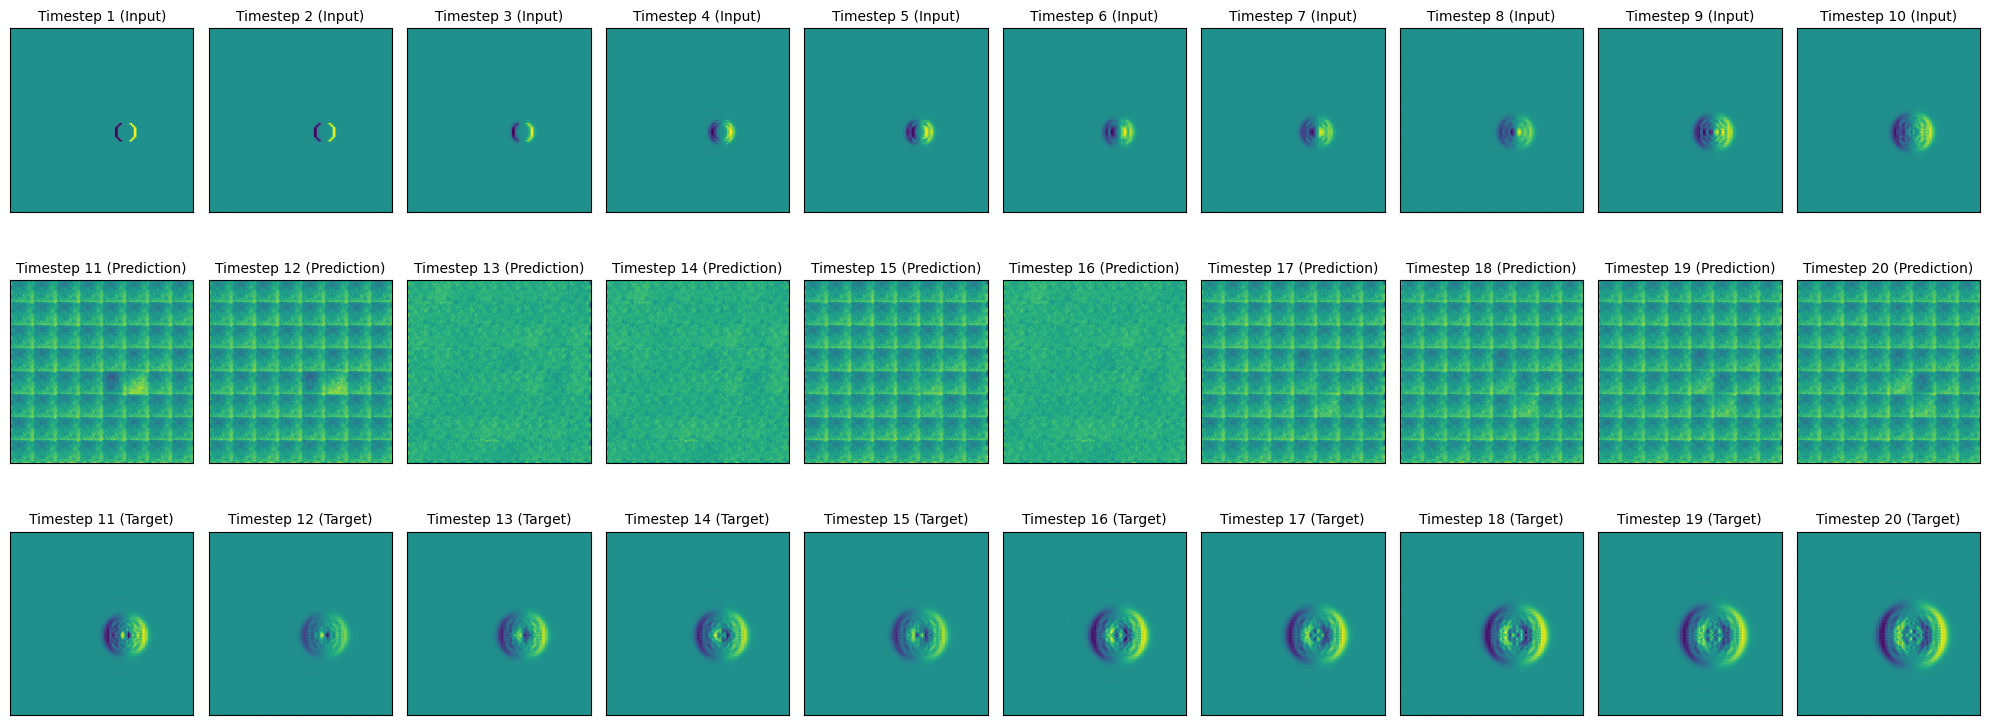

In [10]:
valid_loss = eval(model, val_loader, 0.3,loss_fn, device)

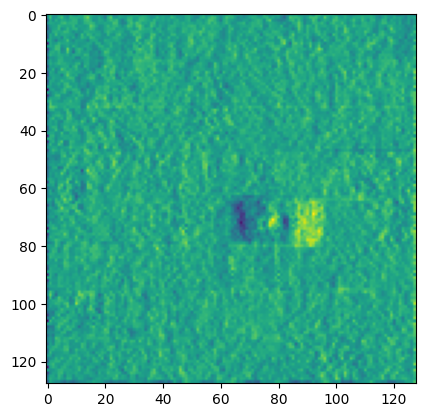

In [49]:
i,j = 0,0
aa = output[i][j][0].cpu().detach().numpy()
plt.imshow(aa)